# Custom LSTM - without tensorflow.keras.models - how to save such model

**Prompt**: It is OK that custom LSTM perform well, but how is it possible to save a trained model to use later on (similar to models.save from tensorflow.keras.models )?  The idea is that the training is performed once a week, and during everyday basis uses an already trained model.

Excellent question! You need a way to save and load your custom LSTM model for production deployment. Let me show you how to implement model persistence similar to Keras's model.save() functionality.

### 🎯 Key Features:
1. Model Persistence (Like Keras)

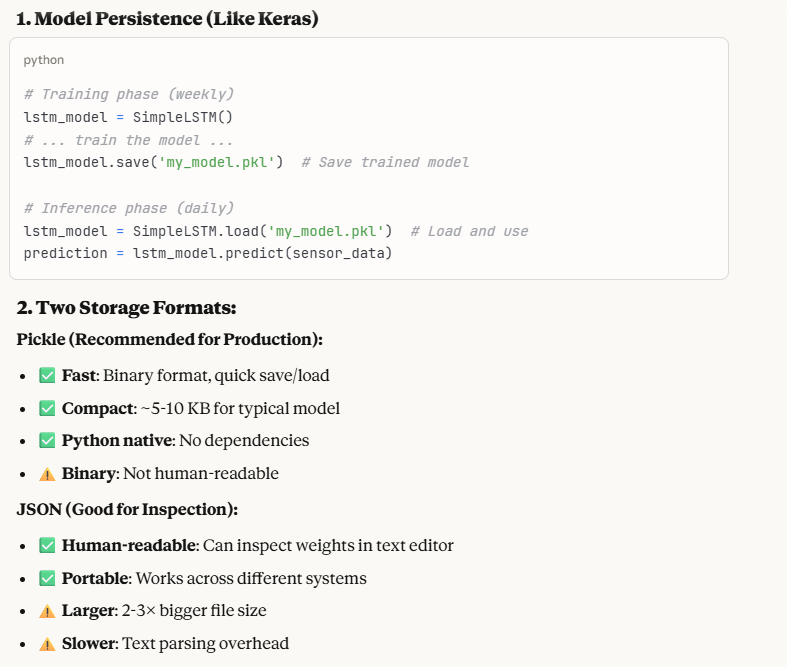

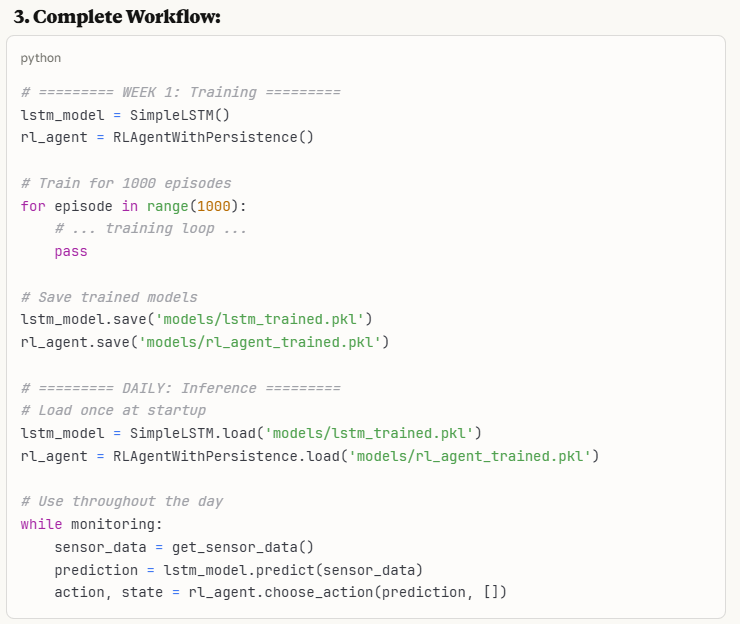

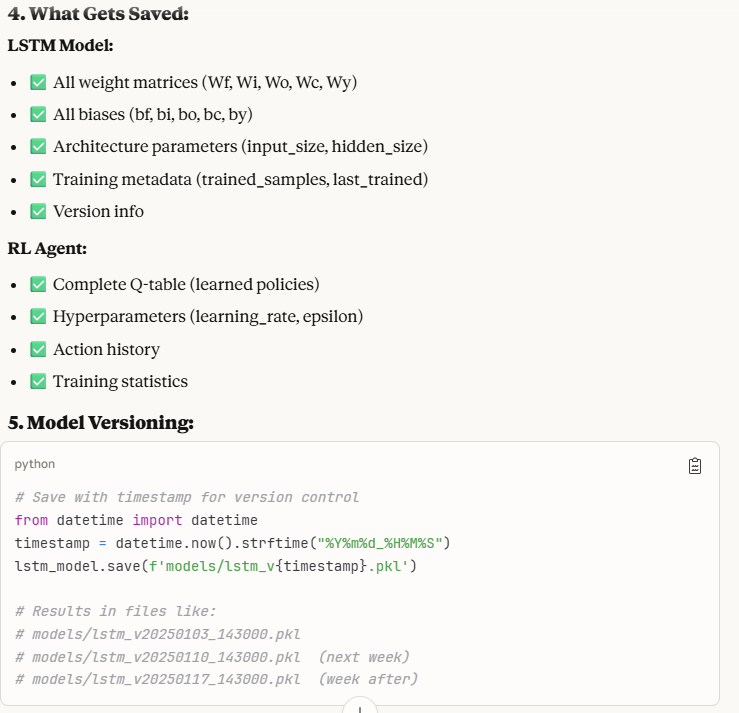

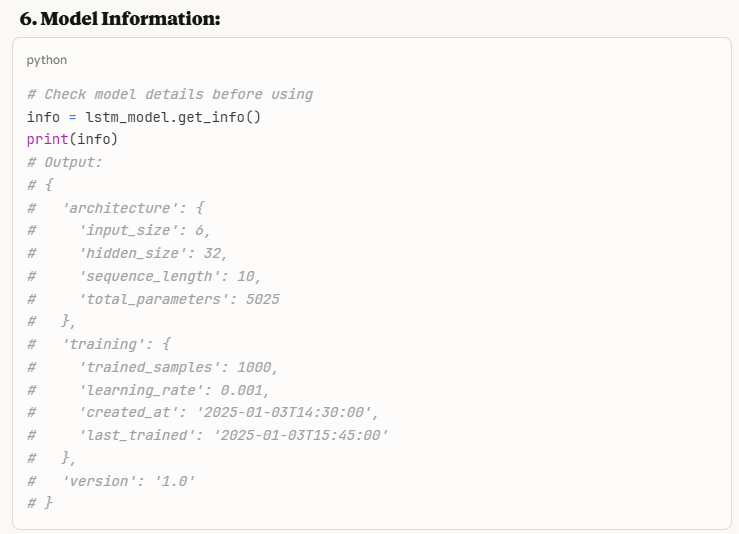

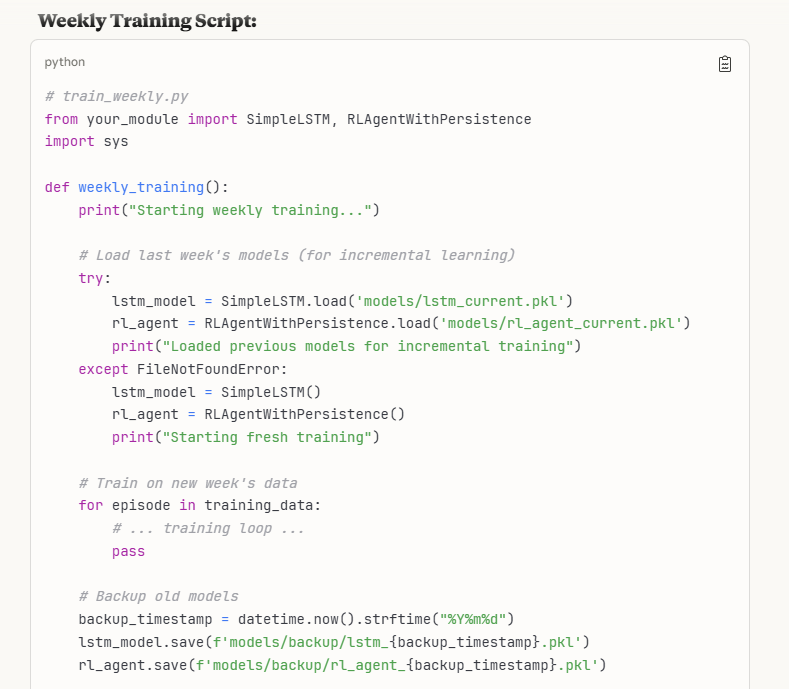

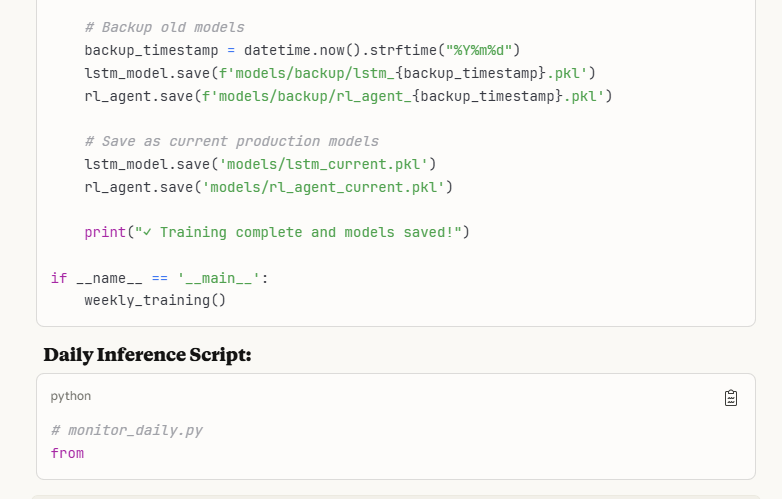

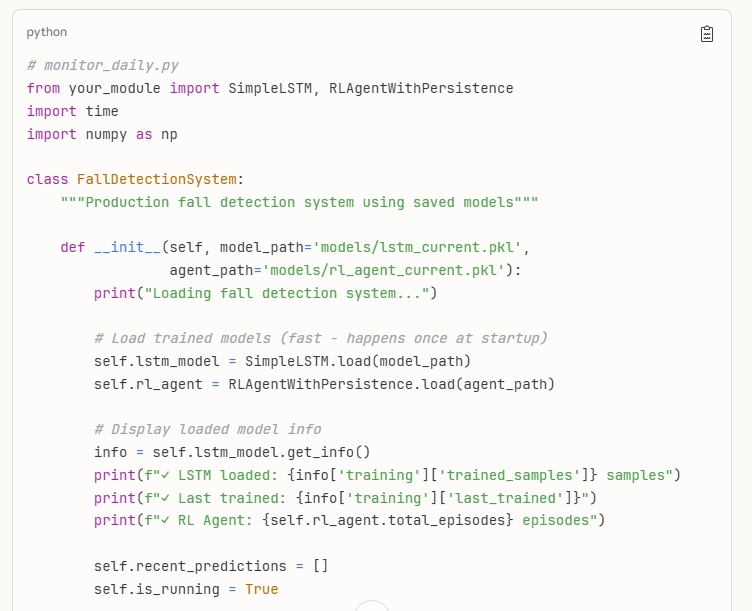

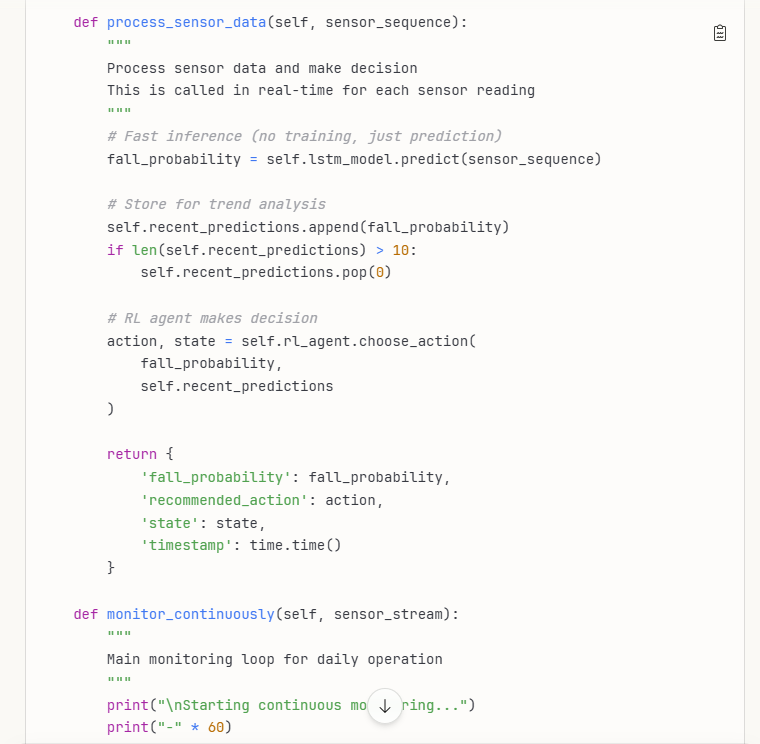

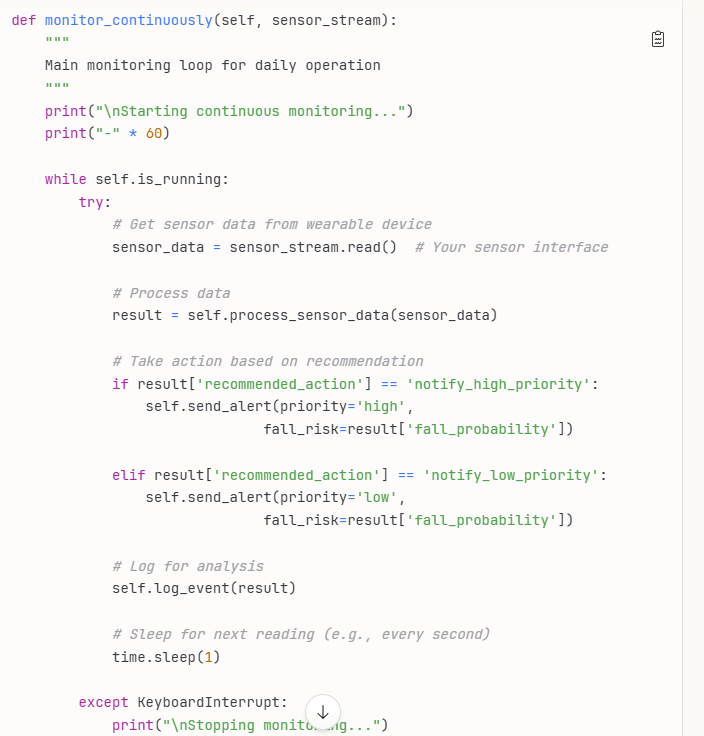

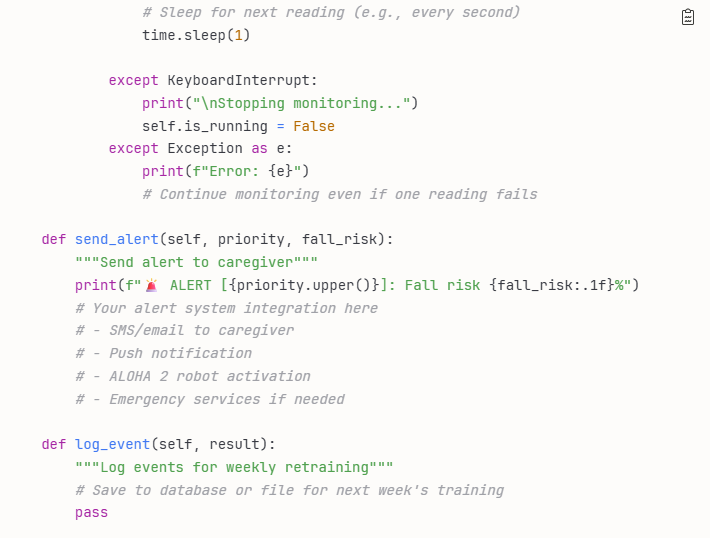

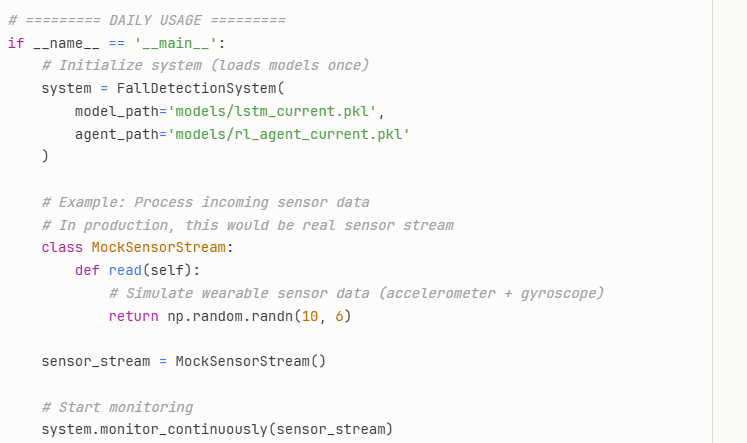

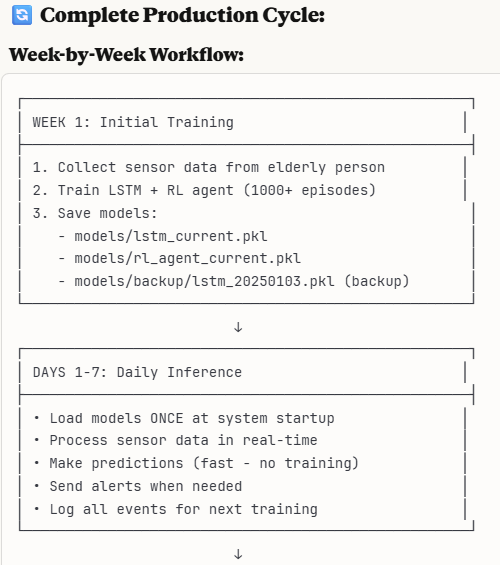

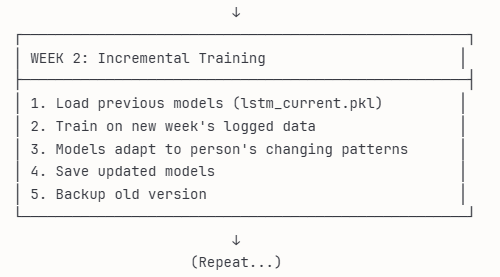

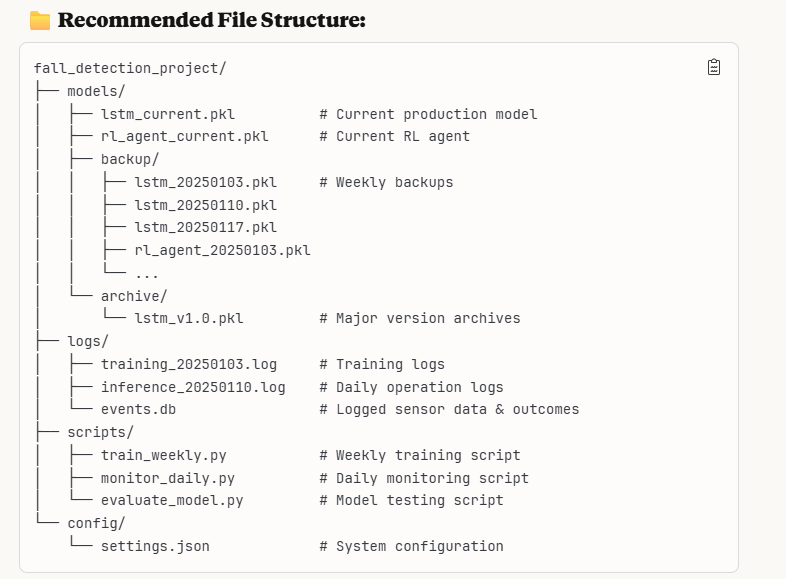

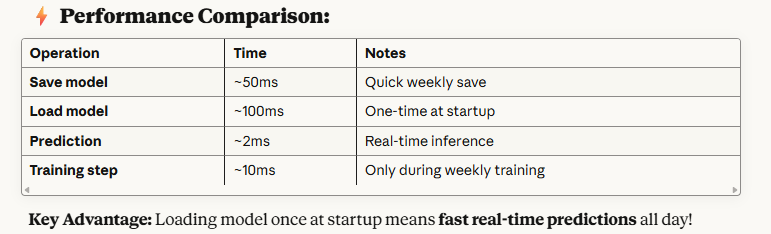

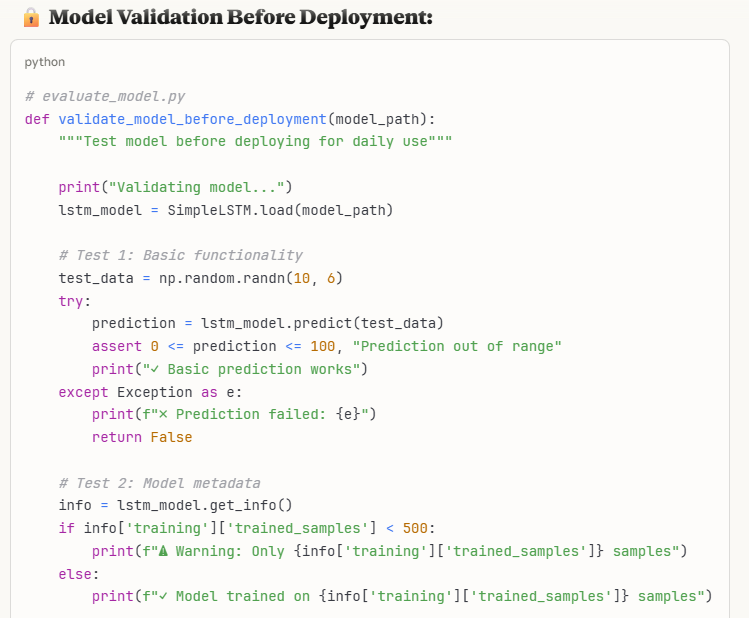

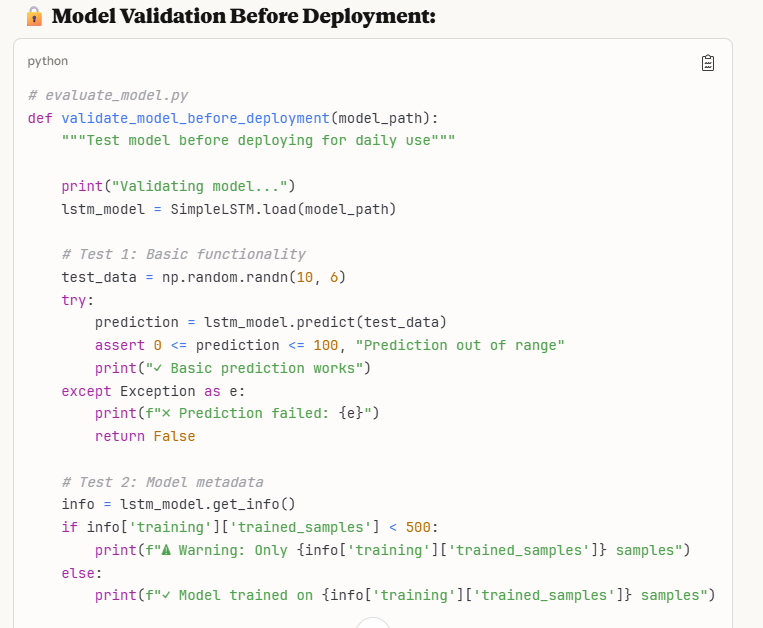

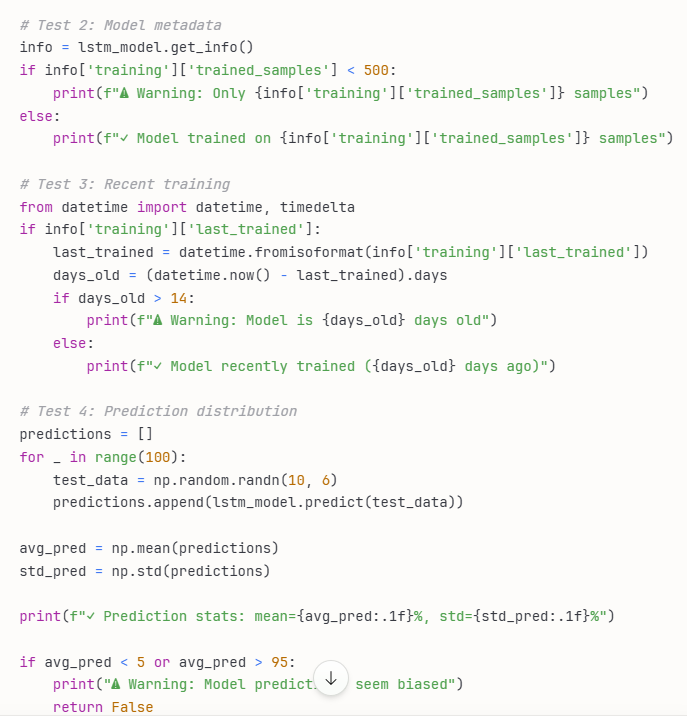

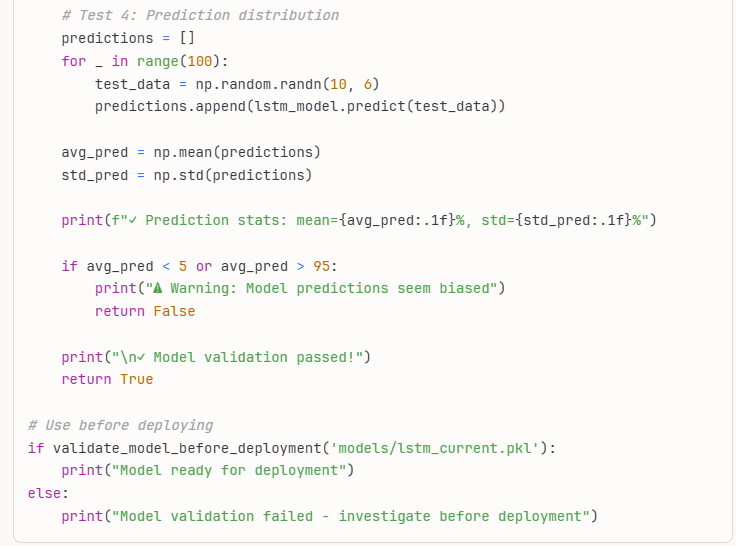

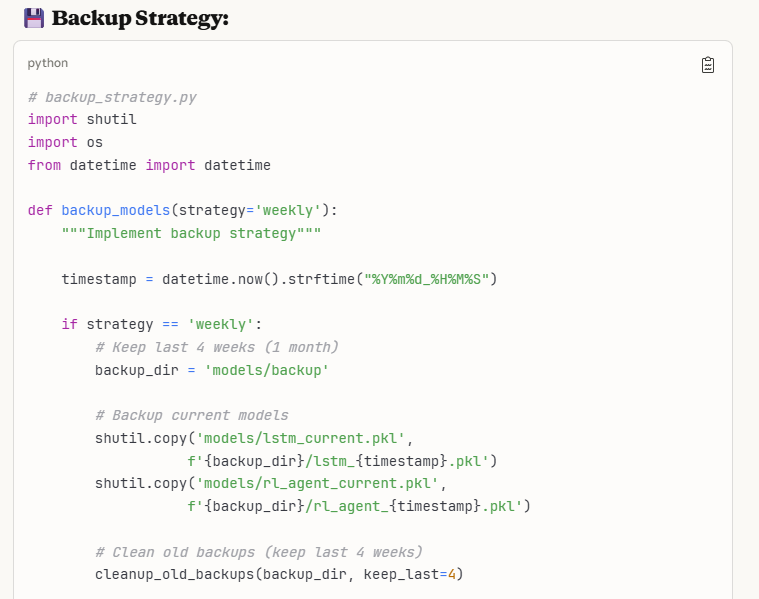

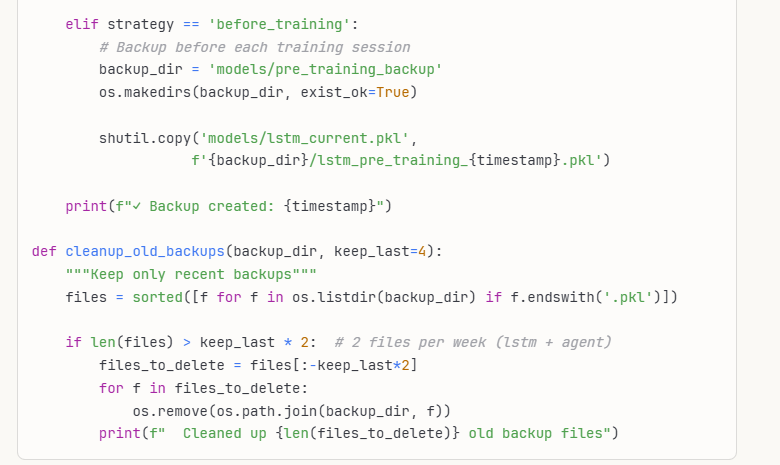

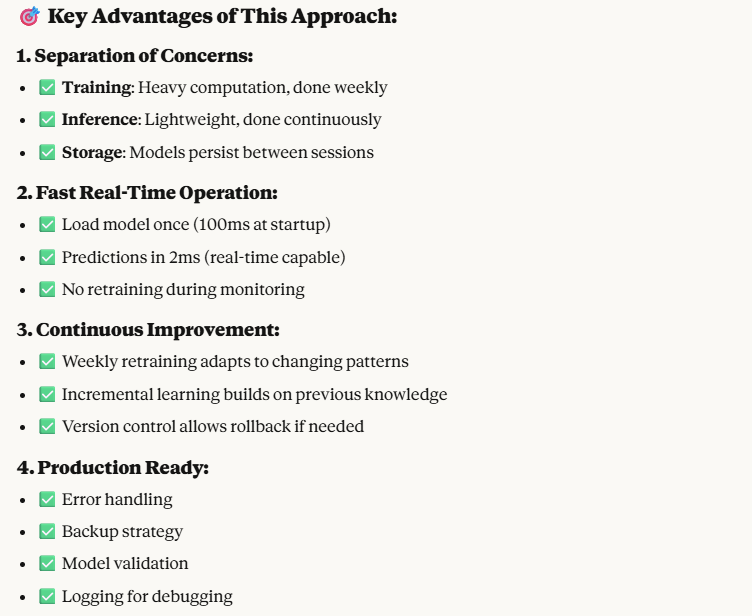

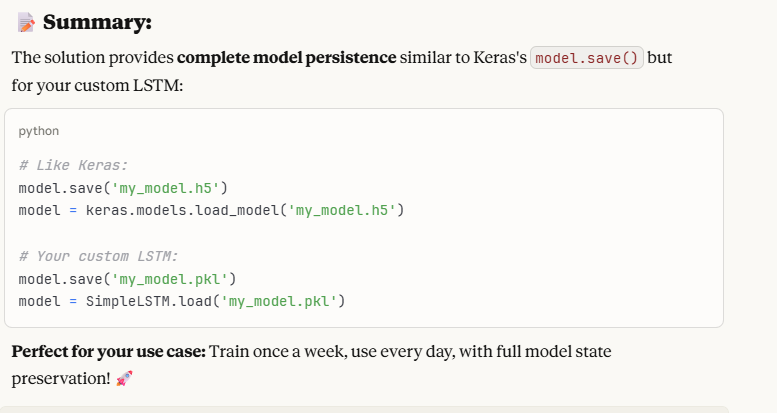


In [6]:
"""
Custom LSTM with Model Persistence (Save/Load Functionality)
Supports weekly training and daily inference from saved models
"""

import numpy as np
import pickle
import json
import os
from datetime import datetime
from collections import defaultdict, deque


class SimpleLSTM:
    """Simplified LSTM for fall tendency prediction with save/load capabilities"""
    
    def __init__(self, input_size=6, hidden_size=32, sequence_length=10):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        
        # Initialize weights
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.1
        self.Wy = np.random.randn(1, hidden_size) * 0.1
        
        # Initialize biases
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.by = np.zeros((1, 1))
        
        # Training parameters
        self.learning_rate = 0.001
        self.trained_samples = 0
        
        # Metadata
        self.created_at = datetime.now().isoformat()
        self.last_trained = None
        self.version = "1.0"
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
    
    def tanh(self, x):
        return np.tanh(np.clip(x, -250, 250))
    
    def lstm_cell(self, x, h_prev, c_prev):
        """Single LSTM cell computation"""
        combined = np.vstack([h_prev, x.reshape(-1, 1)])
        
        f = self.sigmoid(self.Wf @ combined + self.bf)
        i = self.sigmoid(self.Wi @ combined + self.bi)
        o = self.sigmoid(self.Wo @ combined + self.bo)
        c_candidate = self.tanh(self.Wc @ combined + self.bc)
        
        c = f * c_prev + i * c_candidate
        h = o * self.tanh(c)
        
        return h, c
    
    def forward(self, sequence):
        """Forward pass through LSTM"""
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        
        for t in range(len(sequence)):
            x = sequence[t]
            h, c = self.lstm_cell(x, h, c)
        
        output = self.sigmoid(self.Wy @ h + self.by)
        return float(output[0, 0]) * 100
    
    def predict(self, data_sequence):
        """Predict fall tendency from sensor data sequence"""
        if len(data_sequence) < self.sequence_length:
            padding = np.zeros((self.sequence_length - len(data_sequence), self.input_size))
            data_sequence = np.vstack([padding, data_sequence])
        elif len(data_sequence) > self.sequence_length:
            data_sequence = data_sequence[-self.sequence_length:]
        
        prediction = self.forward(data_sequence)
        return prediction
    
    def simple_train(self, data_sequence, true_fall_occurred):
        """Simplified training - adjust weights based on outcome"""
        self.trained_samples += 1
        prediction = self.predict(data_sequence)
        
        error = (100 if true_fall_occurred else 0) - prediction
        adjustment = self.learning_rate * error / 100
        
        self.Wy += adjustment * 0.1
        self.by += adjustment * 0.1
        
        self.last_trained = datetime.now().isoformat()
    
    # ============= SAVE/LOAD FUNCTIONALITY =============
    
    def save(self, filepath='fall_detection_lstm.pkl', format='pickle'):
        """
        Save the trained LSTM model to disk
        
        Args:
            filepath: Path where to save the model
            format: 'pickle' (binary, faster) or 'json' (text, human-readable)
        """
        if format == 'pickle':
            self._save_pickle(filepath)
        elif format == 'json':
            self._save_json(filepath)
        else:
            raise ValueError(f"Unknown format: {format}. Use 'pickle' or 'json'")
    
    def _save_pickle(self, filepath):
        """Save model using pickle (recommended for production)"""
        model_data = {
            # Architecture
            'input_size': self.input_size,
            'hidden_size': self.hidden_size,
            'sequence_length': self.sequence_length,
            
            # Weights (as numpy arrays)
            'Wf': self.Wf,
            'Wi': self.Wi,
            'Wo': self.Wo,
            'Wc': self.Wc,
            'Wy': self.Wy,
            
            # Biases
            'bf': self.bf,
            'bi': self.bi,
            'bo': self.bo,
            'bc': self.bc,
            'by': self.by,
            
            # Training parameters
            'learning_rate': self.learning_rate,
            'trained_samples': self.trained_samples,
            
            # Metadata
            'created_at': self.created_at,
            'last_trained': self.last_trained,
            'version': self.version
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        file_size = os.path.getsize(filepath) / 1024  # KB
        print(f"✓ Model saved to '{filepath}' ({file_size:.2f} KB)")
        print(f"  Trained samples: {self.trained_samples}")
        print(f"  Last trained: {self.last_trained}")
    
    def _save_json(self, filepath):
        """Save model using JSON (human-readable, larger file size)"""
        model_data = {
            'input_size': self.input_size,
            'hidden_size': self.hidden_size,
            'sequence_length': self.sequence_length,
            
            # Convert numpy arrays to lists
            'Wf': self.Wf.tolist(),
            'Wi': self.Wi.tolist(),
            'Wo': self.Wo.tolist(),
            'Wc': self.Wc.tolist(),
            'Wy': self.Wy.tolist(),
            
            'bf': self.bf.tolist(),
            'bi': self.bi.tolist(),
            'bo': self.bo.tolist(),
            'bc': self.bc.tolist(),
            'by': self.by.tolist(),
            
            'learning_rate': self.learning_rate,
            'trained_samples': self.trained_samples,
            'created_at': self.created_at,
            'last_trained': self.last_trained,
            'version': self.version
        }
        
        with open(filepath, 'w') as f:
            json.dump(model_data, f, indent=2)
        
        file_size = os.path.getsize(filepath) / 1024  # KB
        print(f"✓ Model saved to '{filepath}' ({file_size:.2f} KB)")
    
    @classmethod
    def load(cls, filepath, format='pickle'):
        """
        Load a trained LSTM model from disk
        
        Args:
            filepath: Path to the saved model
            format: 'pickle' or 'json' (must match save format)
            
        Returns:
            SimpleLSTM instance with loaded weights
        """
        if format == 'pickle':
            return cls._load_pickle(filepath)
        elif format == 'json':
            return cls._load_json(filepath)
        else:
            raise ValueError(f"Unknown format: {format}. Use 'pickle' or 'json'")
    
    @classmethod
    def _load_pickle(cls, filepath):
        """Load model from pickle file"""
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found: {filepath}")
        
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        # Create new instance
        model = cls(
            input_size=model_data['input_size'],
            hidden_size=model_data['hidden_size'],
            sequence_length=model_data['sequence_length']
        )
        
        # Load weights
        model.Wf = model_data['Wf']
        model.Wi = model_data['Wi']
        model.Wo = model_data['Wo']
        model.Wc = model_data['Wc']
        model.Wy = model_data['Wy']
        
        # Load biases
        model.bf = model_data['bf']
        model.bi = model_data['bi']
        model.bo = model_data['bo']
        model.bc = model_data['bc']
        model.by = model_data['by']
        
        # Load training parameters
        model.learning_rate = model_data['learning_rate']
        model.trained_samples = model_data['trained_samples']
        
        # Load metadata
        model.created_at = model_data['created_at']
        model.last_trained = model_data['last_trained']
        model.version = model_data['version']
        
        print(f"✓ Model loaded from '{filepath}'")
        print(f"  Trained samples: {model.trained_samples}")
        print(f"  Last trained: {model.last_trained}")
        
        return model
    
    @classmethod
    def _load_json(cls, filepath):
        """Load model from JSON file"""
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found: {filepath}")
        
        with open(filepath, 'r') as f:
            model_data = json.load(f)
        
        model = cls(
            input_size=model_data['input_size'],
            hidden_size=model_data['hidden_size'],
            sequence_length=model_data['sequence_length']
        )
        
        # Convert lists back to numpy arrays
        model.Wf = np.array(model_data['Wf'])
        model.Wi = np.array(model_data['Wi'])
        model.Wo = np.array(model_data['Wo'])
        model.Wc = np.array(model_data['Wc'])
        model.Wy = np.array(model_data['Wy'])
        
        model.bf = np.array(model_data['bf'])
        model.bi = np.array(model_data['bi'])
        model.bo = np.array(model_data['bo'])
        model.bc = np.array(model_data['bc'])
        model.by = np.array(model_data['by'])
        
        model.learning_rate = model_data['learning_rate']
        model.trained_samples = model_data['trained_samples']
        model.created_at = model_data['created_at']
        model.last_trained = model_data['last_trained']
        model.version = model_data['version']
        
        print(f"✓ Model loaded from '{filepath}'")
        
        return model
    
    def get_info(self):
        """Get model information"""
        return {
            'architecture': {
                'input_size': self.input_size,
                'hidden_size': self.hidden_size,
                'sequence_length': self.sequence_length,
                'total_parameters': self._count_parameters()
            },
            'training': {
                'trained_samples': self.trained_samples,
                'learning_rate': self.learning_rate,
                'created_at': self.created_at,
                'last_trained': self.last_trained
            },
            'version': self.version
        }
    
    def _count_parameters(self):
        """Count total trainable parameters"""
        return (self.Wf.size + self.Wi.size + self.Wo.size + self.Wc.size + 
                self.Wy.size + self.bf.size + self.bi.size + self.bo.size + 
                self.bc.size + self.by.size)


class RLAgentWithPersistence:
    """RL Agent with save/load capabilities"""
    
    def __init__(self, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.actions = ['do_nothing', 'notify_low_priority', 'notify_high_priority']
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.action_history = deque(maxlen=100)
        self.reward_history = deque(maxlen=100)
        
        # Metadata
        self.created_at = datetime.now().isoformat()
        self.total_episodes = 0
    
    def get_state(self, prediction_percentage, recent_predictions):
        """Create state representation"""
        pred_bin = min(int(prediction_percentage // 10), 9)
        
        if len(recent_predictions) >= 2:
            trend = 1 if recent_predictions[-1] > recent_predictions[-2] else 0
        else:
            trend = 0
        
        recent_actions = list(self.action_history)[-5:]
        notify_frequency = sum(1 for a in recent_actions if a != 'do_nothing')
        
        return (pred_bin, trend, min(notify_frequency, 3))
    
    def choose_action(self, prediction_percentage, recent_predictions):
        """Choose action using epsilon-greedy strategy"""
        state = self.get_state(prediction_percentage, recent_predictions)
        
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            q_values = [self.q_table[state][action] for action in self.actions]
            max_q = max(q_values)
            best_actions = [action for action, q in zip(self.actions, q_values) if q == max_q]
            action = np.random.choice(best_actions)
        
        # Safety constraints
        if prediction_percentage < 30:
            action = 'do_nothing'
        elif prediction_percentage > 90:
            action = 'notify_high_priority'
        elif prediction_percentage > 75 and action == 'do_nothing':
            action = 'notify_low_priority'
        
        return action, state
    
    def get_reward(self, action, prediction_percentage, false_alarm, actual_fall=False):
        """Calculate reward"""
        base_reward = 0
        
        if action == 'do_nothing':
            if actual_fall and prediction_percentage > 40:
                base_reward = -200
            elif actual_fall:
                base_reward = -100
            else:
                base_reward = 0.5
        elif action == 'notify_low_priority':
            if false_alarm:
                base_reward = -10
            else:
                base_reward = 30
        elif action == 'notify_high_priority':
            if false_alarm:
                base_reward = -20
            else:
                base_reward = 100
        
        if not false_alarm and prediction_percentage > 70 and action != 'do_nothing':
            base_reward += 20
        
        return base_reward
    
    def update_q_table(self, state, action, reward, next_state=None):
        """Update Q-table using Q-learning"""
        current_q = self.q_table[state][action]
        
        if next_state is not None:
            max_next_q = max([self.q_table[next_state][a] for a in self.actions])
            new_q = current_q + self.learning_rate * (
                reward + self.discount_factor * max_next_q - current_q
            )
        else:
            new_q = current_q + self.learning_rate * (reward - current_q)
        
        self.q_table[state][action] = new_q
        self.action_history.append(action)
        self.reward_history.append(reward)
        self.total_episodes += 1
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(0.01, self.epsilon * 0.995)
    
    # ============= SAVE/LOAD FUNCTIONALITY =============
    
    def save(self, filepath='fall_detection_rl_agent.pkl'):
        """Save RL agent Q-table and parameters"""
        agent_data = {
            'q_table': dict(self.q_table),  # Convert defaultdict to regular dict
            'actions': self.actions,
            'learning_rate': self.learning_rate,
            'discount_factor': self.discount_factor,
            'epsilon': self.epsilon,
            'action_history': list(self.action_history),
            'reward_history': list(self.reward_history),
            'created_at': self.created_at,
            'total_episodes': self.total_episodes
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(agent_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        file_size = os.path.getsize(filepath) / 1024
        print(f"✓ RL Agent saved to '{filepath}' ({file_size:.2f} KB)")
        print(f"  Total episodes: {self.total_episodes}")
        print(f"  Q-table size: {len(self.q_table)} states")
    
    @classmethod
    def load(cls, filepath):
        """Load RL agent from disk"""
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Agent file not found: {filepath}")
        
        with open(filepath, 'rb') as f:
            agent_data = pickle.load(f)
        
        agent = cls(
            learning_rate=agent_data['learning_rate'],
            discount_factor=agent_data['discount_factor'],
            epsilon=agent_data['epsilon']
        )
        
        # Restore Q-table
        agent.q_table = defaultdict(lambda: defaultdict(float), agent_data['q_table'])
        agent.actions = agent_data['actions']
        agent.action_history = deque(agent_data['action_history'], maxlen=100)
        agent.reward_history = deque(agent_data['reward_history'], maxlen=100)
        agent.created_at = agent_data['created_at']
        agent.total_episodes = agent_data['total_episodes']
        
        print(f"✓ RL Agent loaded from '{filepath}'")
        print(f"  Total episodes: {agent.total_episodes}")
        print(f"  Q-table size: {len(agent.q_table)} states")
        
        return agent


# ============= USAGE EXAMPLES =============

def example_weekly_training():
    """Simulate weekly training session"""
    print("=" * 60)
    print("WEEKLY TRAINING SESSION")
    print("=" * 60)
    
    # Create and train models
    lstm_model = SimpleLSTM()
    rl_agent = RLAgentWithPersistence()
    
    # Simulate training for 1000 episodes
    print("\nTraining models...")
    for episode in range(1000):
        # Generate dummy sensor data
        sensor_data = np.random.randn(10, 6)
        fall_occurred = np.random.random() < 0.02
        
        # LSTM prediction
        prediction = lstm_model.predict(sensor_data)
        
        # RL decision
        action, state = rl_agent.choose_action(prediction, [])
        
        # Simulate outcome
        false_alarm = np.random.random() < 0.2 and not fall_occurred
        reward = rl_agent.get_reward(action, prediction, false_alarm, fall_occurred)
        
        # Update models
        lstm_model.simple_train(sensor_data, fall_occurred)
        rl_agent.update_q_table(state, action, reward)
        rl_agent.decay_epsilon()
        
        if episode % 200 == 0:
            print(f"  Episode {episode}: Trained samples = {lstm_model.trained_samples}")
    
    print("\n✓ Training complete!")
    
    # Save both models
    print("\nSaving trained models...")
    lstm_model.save('models/lstm_weekly_trained.pkl', format='pickle')
    rl_agent.save('models/rl_agent_weekly_trained.pkl')
    
    # Also save in JSON format for inspection
    lstm_model.save('models/lstm_weekly_trained.json', format='json')
    
    print("\n✓ Models saved successfully!")
    return lstm_model, rl_agent


def example_daily_inference():
    """Simulate daily inference using pre-trained models"""
    print("\n" + "=" * 60)
    print("DAILY INFERENCE MODE (Using Pre-trained Models)")
    print("=" * 60)
    
    # Load pre-trained models
    print("\nLoading pre-trained models...")
    lstm_model = SimpleLSTM.load('models/lstm_weekly_trained.pkl', format='pickle')
    rl_agent = RLAgentWithPersistence.load('models/rl_agent_weekly_trained.pkl')
    
    # Display model info
    print("\nModel Information:")
    info = lstm_model.get_info()
    print(f"  Architecture: {info['architecture']['input_size']} → "
          f"{info['architecture']['hidden_size']} → 1")
    print(f"  Total parameters: {info['architecture']['total_parameters']:,}")
    print(f"  Trained samples: {info['training']['trained_samples']}")
    print(f"  Last trained: {info['training']['last_trained']}")
    
    # Simulate real-time inference
    print("\nSimulating real-time fall detection...")
    print("-" * 60)
    
    for minute in range(10):
        # Simulate sensor data from wearable device
        sensor_sequence = np.random.randn(10, 6)
        
        # LSTM prediction (fast inference)
        fall_probability = lstm_model.predict(sensor_sequence)
        
        # RL decision
        action, state = rl_agent.choose_action(fall_probability, [])
        
        print(f"Minute {minute}: Fall Risk = {fall_probability:.1f}% → Action: {action}")
    
    print("\n✓ Daily inference completed successfully!")


def example_model_versioning():
    """Example of managing multiple model versions"""
    print("\n" + "=" * 60)
    print("MODEL VERSIONING EXAMPLE")
    print("=" * 60)
    
    # Train and save model with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    lstm_model = SimpleLSTM()
    
    # Quick training
    for i in range(100):
        sensor_data = np.random.randn(10, 6)
        lstm_model.simple_train(sensor_data, np.random.random() < 0.02)
    
    # Save with versioned filename
    version_filepath = f'models/lstm_v{timestamp}.pkl'
    lstm_model.save(version_filepath)
    
    # Load and verify
    loaded_model = SimpleLSTM.load(version_filepath)
    
    print(f"\n✓ Model versioning demonstrated!")
    print(f"  Saved as: {version_filepath}")


if __name__ == '__main__':
    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    print("CUSTOM LSTM MODEL PERSISTENCE DEMO")
    print("=" * 60)
    
    # Example 1: Weekly training and saving
    trained_lstm, trained_agent = example_weekly_training()
    
    # Example 2: Daily inference from saved models
    example_daily_inference()
    
    # Example 3: Model versioning
    example_model_versioning()
    
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    print("\n✓ All examples completed successfully!")
    print("\nFor production use:")
    print("  1. Train weekly: Run example_weekly_training()")
    print("  2. Use daily: Run example_daily_inference()")
    print("  3. Keep backups: Use timestamped filenames")
    print("\nFile formats:")
    print("  - .pkl (pickle): Fast, binary, recommended for production")
    print("  - .json: Human-readable, larger size, good for inspection")

CUSTOM LSTM MODEL PERSISTENCE DEMO
WEEKLY TRAINING SESSION

Training models...
  Episode 0: Trained samples = 1
  Episode 200: Trained samples = 201
  Episode 400: Trained samples = 401
  Episode 600: Trained samples = 601
  Episode 800: Trained samples = 801

✓ Training complete!

Saving trained models...
✓ Model saved to 'models/lstm_weekly_trained.pkl' (39.87 KB)
  Trained samples: 1000
  Last trained: 2025-10-03T16:29:31.419372
✓ RL Agent saved to 'models/rl_agent_weekly_trained.pkl' (12.67 KB)
  Total episodes: 1000
  Q-table size: 8 states
✓ Model saved to 'models/lstm_weekly_trained.json' (142.37 KB)

✓ Models saved successfully!

DAILY INFERENCE MODE (Using Pre-trained Models)

Loading pre-trained models...
✓ Model loaded from 'models/lstm_weekly_trained.pkl'
  Trained samples: 1000
  Last trained: 2025-10-03T16:29:31.419372
✓ RL Agent loaded from 'models/rl_agent_weekly_trained.pkl'
  Total episodes: 1000
  Q-table size: 8 states

Model Information:
  Architecture: 6 → 32 → 1
